<a href="https://colab.research.google.com/github/Pranav24112004/Legal_Case_Similarity/blob/main/Using_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

In [6]:
import numpy as np

In [7]:
df=pd.read_csv('/content/output (1).csv')

In [8]:
df.head()

,Text
0,Appeal No. 101 of 1959.\nAppeal by special lea...
1,Appeal No. 52 of 1957.\nAppeal from the judgme...
2,Appeals Nos. 45 and 46 of 1959.\nAppeal by spe...
3,ION: Criminal Appeal 89 of 1961.\nAppeal by sp...
4,Civil Appeal No. 50 of 1961.\nAppeal by specia...


In [9]:
df.shape

(109, 1)

In [10]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [11]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLP resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Define legal stopwords
legal_stopwords = set(stopwords.words('english')) | {"plaintiff", "defendant", "judgment", "court", "bench", "vs", "v", "no"}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean legal text
def clean_legal_text(text):
    if pd.isna(text):  # Handle missing values
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove unwanted characters (punctuation, numbers, special chars)
    text = re.sub(r'[\d]+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces & line breaks
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Remove case metadata (case numbers, citations, extra references)
    text = re.sub(r'appeal no \d+ of \d+', '', text)
    text = re.sub(r'case no \d+', '', text)
    text = re.sub(r'judgment in \d+', '', text)

    # Tokenize and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word not in legal_stopwords]

    # Lemmatization (reduce words to base form)
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply the function to clean text
df["Cleaned_Text"] = df["Text"].apply(clean_legal_text)

# Save the cleaned dataset
output_file = "fully_cleaned_legal_cases.csv"
df.to_csv(output_file, index=False)

print(f"Fully cleaned dataset saved as {output_file}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fully cleaned dataset saved as fully_cleaned_legal_cases.csv


In [12]:
import pandas as pd
import os
import zipfile
from google.colab import files  # Only needed for downloading in Google Colab

# Load dataset
df = pd.read_csv("/content/fully_cleaned_legal_cases.csv")

# Create a directory to store text files
output_dir = "case_texts"
os.makedirs(output_dir, exist_ok=True)

# Convert each row into a text file
for index, row in df.iterrows():
    case_text = row["Cleaned_Text"]  # Use the column name where case text is stored
    file_name = f"{output_dir}/case_{index}.txt"

    with open(file_name, "w", encoding="utf-8") as f:
        f.write(case_text)

# Zip all text files
zip_filename = "case_texts.zip"
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for file in os.listdir(output_dir):
        zipf.write(os.path.join(output_dir, file), file)

# Download ZIP file (Only for Google Colab)
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df.head()

,Text,Cleaned_Text
0,Appeal No. 101 of 1959.\nAppeal by special lea...,appeal appeal special leave order dated novemb...
1,Appeal No. 52 of 1957.\nAppeal from the judgme...,appeal appeal decree dated april patna high ap...
2,Appeals Nos. 45 and 46 of 1959.\nAppeal by spe...,appeal no appeal special leave order dated mar...
3,ION: Criminal Appeal 89 of 1961.\nAppeal by sp...,ion criminal appeal appeal special leave order...
4,Civil Appeal No. 50 of 1961.\nAppeal by specia...,civil appeal appeal special leave award dated ...


In [14]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import NMF
from collections import Counter

# Load cleaned dataset
file_path = "fully_cleaned_legal_cases.csv"  # Update with your actual file
df = pd.read_csv(file_path)

# Ensure text is in string format
df["Cleaned_Text"] = df["Cleaned_Text"].astype(str)

### **1️⃣ TF-IDF Cosine Similarity**
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df["Cleaned_Text"])
tfidf_similarity = cosine_similarity(tfidf_matrix)

### **2️⃣ Sentence Embeddings (BERT/SBERT)**
model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight BERT Model
embeddings = model.encode(df["Cleaned_Text"], convert_to_tensor=True)
bert_similarity = cosine_similarity(embeddings.cpu().numpy())

### **3️⃣ Jaccard Similarity (Legal Keywords Overlap)**
def jaccard_similarity(text1, text2):
    words_text1 = set(re.findall(r'\w+', text1.lower()))
    words_text2 = set(re.findall(r'\w+', text2.lower()))
    intersection = words_text1.intersection(words_text2)
    union = words_text1.union(words_text2)
    return len(intersection) / len(union) if union else 0

# Compute pairwise Jaccard Similarity
num_cases = len(df)
jaccard_matrix = np.zeros((num_cases, num_cases))

for i in range(num_cases):
    for j in range(i, num_cases):  # Optimize by computing only upper triangle
        jaccard_sim = jaccard_similarity(df["Cleaned_Text"].iloc[i], df["Cleaned_Text"].iloc[j])
        jaccard_matrix[i][j] = jaccard_sim
        jaccard_matrix[j][i] = jaccard_sim  # Symmetric matrix

### **4️⃣ Topic Modeling (LDA/NMF)**
nmf_model = NMF(n_components=10, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_matrix)
topic_similarity = cosine_similarity(topic_matrix)

### **Combine All Similarity Scores Using Equal Weights**
final_similarity = (0.25 * tfidf_similarity) + (0.25 * bert_similarity) + (0.25 * jaccard_matrix) + (0.25 * topic_similarity)

# Convert to DataFrame and Save
similarity_df = pd.DataFrame(final_similarity, index=df.index, columns=df.index)
similarity_df.to_csv("legal_case_similarity_scores.csv")

print("Similarity scores computed and saved as 'legal_case_similarity_scores.csv'")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Similarity scores computed and saved as 'legal_case_similarity_scores.csv'


In [15]:
df1=pd.read_csv('/content/legal_case_similarity_scores.csv')

In [16]:
df1.tail()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,99,100,101,102,103,104,105,106,107,108
104,104,0.316527,0.222431,0.212874,0.202848,0.355293,0.267487,0.204737,0.224127,0.560395,...,0.447041,0.266194,0.240359,0.258874,0.228810,1.000000,0.433373,0.184199,0.150006,0.202483
105,105,0.268218,0.159019,0.189164,0.151675,0.257170,0.293925,0.186396,0.187930,0.423260,...,0.384927,0.232040,0.307169,0.198457,0.169872,0.433373,1.000000,0.189240,0.157276,0.219197
106,106,0.149580,0.149688,0.346604,0.219236,0.302589,0.214004,0.194591,0.205271,0.205462,...,0.203025,0.202260,0.190426,0.289245,0.224695,0.184199,0.189240,1.000000,0.509755,0.330730
107,107,0.121077,0.126716,0.221562,0.195068,0.278140,0.196755,0.115159,0.113194,0.138363,...,0.182261,0.163368,0.187017,0.314359,0.134316,0.150006,0.157276,0.509755,1.000000,0.359850
108,108,0.199987,0.180694,0.129773,0.273650,0.272570,0.303330,0.125732,0.137422,0.187171,...,0.208614,0.364437,0.233500,0.195997,0.147961,0.202483,0.219197,0.330730,0.359850,1.000000



🚀 **Manual Training Mode: Enter Case Indexes and Scores**
🔢 Enter Input Case Index (or -1 to stop): 10
🔢 Enter Compared Case Index: 100
👨‍⚖️ Rate the similarity between Case 10 and Case 100 (0-10): 0

🔄 Iteration 1 | Updated Weights: {'TF-IDF': 0.2777777777777778, 'BERT': 0.2777777777777778, 'Jaccard': 0.22222222222222227, 'Topic': 0.22222222222222227}


🚀 **Manual Training Mode: Enter Case Indexes and Scores**
🔢 Enter Input Case Index (or -1 to stop): 10
🔢 Enter Compared Case Index: 101
👨‍⚖️ Rate the similarity between Case 10 and Case 101 (0-10): 2

🔄 Iteration 2 | Updated Weights: {'TF-IDF': 0.30864197530864196, 'BERT': 0.30864197530864196, 'Jaccard': 0.19135802469135807, 'Topic': 0.19135802469135807}


🚀 **Manual Training Mode: Enter Case Indexes and Scores**
🔢 Enter Input Case Index (or -1 to stop): 10
🔢 Enter Compared Case Index: 103
👨‍⚖️ Rate the similarity between Case 10 and Case 103 (0-10): 7

🔄 Iteration 3 | Updated Weights: {'TF-IDF': 0.3177542621987066, 'BERT': 0.31775426

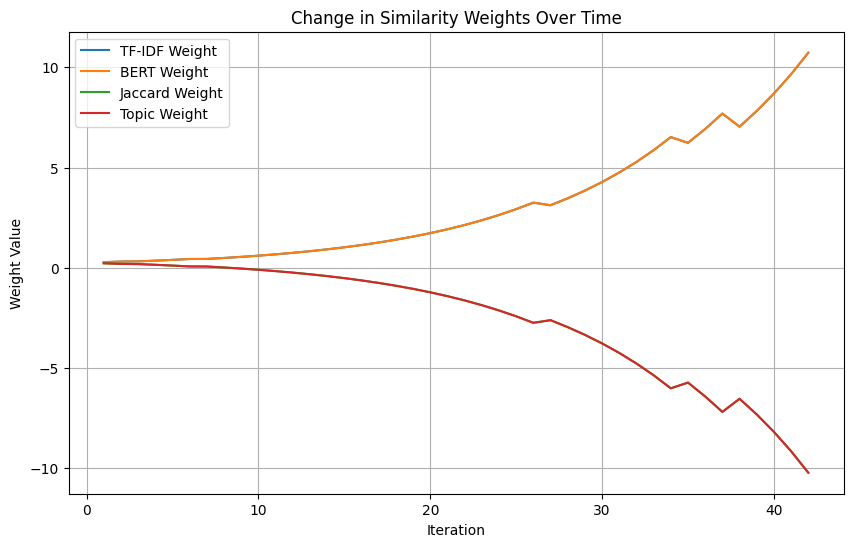

In [17]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

# Load dataset and similarity matrix
cases_df = pd.read_csv("/content/fully_cleaned_legal_cases.csv")
similarity_df = pd.read_csv("/content/legal_case_similarity_scores.csv", index_col=0)

# Convert index to integers
similarity_df.index = similarity_df.index.astype(int)
similarity_df.columns = similarity_df.columns.astype(int)

# Initial Weights for Similarity Methods
weights = {"TF-IDF": 0.25, "BERT": 0.25, "Jaccard": 0.25, "Topic": 0.25}

# CSV file to log weight changes over iterations
log_file = "training_progress_log.csv"

# Initialize log file with headers if not already created
with open(log_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Input Case Index", "Compared Case Index", "Similarity Score", "Feedback Score",
                     "TF-IDF Weight", "BERT Weight", "Jaccard Weight", "Topic Weight"])

# Function to update weights based on user feedback
def update_weights_and_log(iteration, case_index, compared_case_index, similarity_score, feedback_score, contributing_methods):
    global weights
    learning_rate = 0.05  # Small update step

    # Adjust learning rate based on feedback score
    if feedback_score >= 8:
        adjustment = learning_rate  # Large positive adjustment
    elif 5 <= feedback_score < 8:
        adjustment = learning_rate / 2  # Small positive adjustment
    else:
        adjustment = -learning_rate  # Decrease weight for bad matches

    # Update weights for contributing methods
    for method in weights.keys():
        if method in contributing_methods:
            weights[method] += adjustment

    # Normalize weights so they sum to 1
    total_weight = sum(weights.values())
    weights = {k: v / total_weight for k, v in weights.items()}

    # Log feedback & weight updates
    with open(log_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([iteration, case_index, compared_case_index, similarity_score, feedback_score,
                         weights["TF-IDF"], weights["BERT"], weights["Jaccard"], weights["Topic"]])

    print(f"\n🔄 Iteration {iteration} | Updated Weights: {weights}\n")

# Function to manually input case indexes and scores
def manual_training():
    iteration = 1
    while True:
        print("\n🚀 **Manual Training Mode: Enter Case Indexes and Scores**")
        try:
            case_x = int(input("🔢 Enter Input Case Index (or -1 to stop): "))
            if case_x == -1:
                print("\n✅ Training Stopped. Generating Graph...")
                break

            case_y = int(input("🔢 Enter Compared Case Index: "))

            if case_x not in similarity_df.index or case_y not in similarity_df.index:
                print("⚠️ Invalid case index! Please enter valid indexes from the dataset.")
                continue

            similarity_score = similarity_df.loc[case_x, case_y]

            # User inputs a similarity rating (0-10)
            while True:
                try:
                    score = int(input(f"👨‍⚖️ Rate the similarity between Case {case_x} and Case {case_y} (0-10): "))
                    if 0 <= score <= 10:
                        break
                    else:
                        print("⚠️ Please enter a score between 0 and 10.")
                except ValueError:
                    print("⚠️ Invalid input. Enter a number between 0 and 10.")

            # Adjust weights based on score & log changes
            contributing_methods = ["TF-IDF", "BERT"] if score >= 5 else ["Jaccard", "Topic"]
            update_weights_and_log(iteration, case_x, case_y, similarity_score, score, contributing_methods)

            iteration += 1

        except ValueError:
            print("⚠️ Invalid input! Please enter numbers only.")

# Run manual training
manual_training()

# Load log file and plot weight changes
def plot_weight_changes():
    log_df = pd.read_csv(log_file)

    plt.figure(figsize=(10, 6))
    for method in ["TF-IDF Weight", "BERT Weight", "Jaccard Weight", "Topic Weight"]:
        plt.plot(log_df["Iteration"], log_df[method], label=method)

    plt.xlabel("Iteration")
    plt.ylabel("Weight Value")
    plt.title("Change in Similarity Weights Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# Plot learning progress
plot_weight_changes()